In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import PIL
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tqdm
import copy

In [0]:
batch_size=128
lr=1e-3
num_epochs = 30

In [0]:
transforms_dict = {'train':torchvision.transforms.Compose([
                                                           torchvision.transforms.RandomHorizontalFlip(),
                                                           torchvision.transforms.ToTensor(),
                                                           torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                           ]),
                   'test':torchvision.transforms.Compose([
                                                          torchvision.transforms.ToTensor(),
                                                          torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                   ])    
}

In [4]:
train_ds = torchvision.datasets.CIFAR10(root='.',train=True,transform=transforms_dict['train'],download=True)
test_ds = torchvision.datasets.CIFAR10(root='.',train=False, transform=transforms_dict['test'], download=True)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


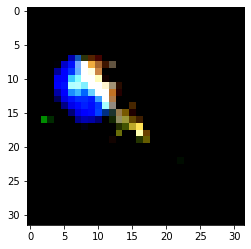

In [9]:
plt.imshow(next(iter(train_dl))[0][0].permute(1,2,0))

In [0]:
class Encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # 32x32 -> 16x16
    self.block1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, 4, 2, 1),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),        
    )
    
    # 16x16 -> 8x8
    self.block2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, 4, 2, 1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU()
    )

    # 8x8 -> 4x4
    self.block3 = torch.nn.Sequential(
        torch.nn.Conv2d(64, 128, 4, 2, 1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU()
    )

    # 4x4 -> 2x2
    self.block4 = torch.nn.Sequential(
        torch.nn.Conv2d(128, 256, 4, 2, 1),
        torch.nn.Tanh()
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

class Decoder(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # 2x2 -> 4x4
    self.block1 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(256, 128, 4, 2, 1),
        torch.nn.BatchNorm2d(128),
        torch.nn.LeakyReLU()
    )

    # 4x4 -> 8x8
    self.block2= torch.nn.Sequential(
        torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
        torch.nn.BatchNorm2d(64),
        torch.nn.LeakyReLU()
    )

    # 8x8 -> 16x16
    self.block3 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(64,32,4,2,1),
        torch.nn.BatchNorm2d(32),
        torch.nn.LeakyReLU()
    )

    # 16x16 -> 32x32
    self.block4 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(32, 3, 4, 2, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

enc, dec = Encoder(), Decoder()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


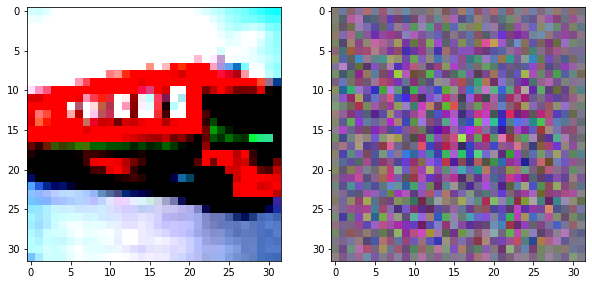

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(next(iter(train_dl))[0][0].permute(1,2,0))

plt.subplot(1,2,2)
plt.imshow(dec(enc(next(iter(train_dl))[0][0].unsqueeze(0)))[0].detach().permute(1,2,0))

In [0]:
class CAE(torch.nn.Module):
  """Convolutional AutoEncoder"""
  def __init__(self):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

  def forward(self, x):
    x = self.enc(x)
    x = self.dec(x)
    return x

  def get_enc(self):
    return copy.deepcopy(self.enc)

  def get_dec(self):
    return copy.deepcopy(self.dec)

In [0]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
net = CAE()
net.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
idx = 0


Epoch 1: loss: 0.74667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 1: loss: 0.66888


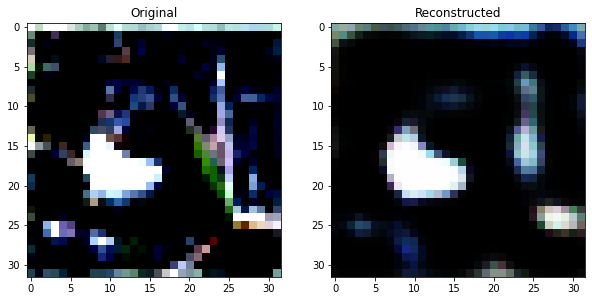


Epoch 2: loss: 0.66921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 2: loss: 0.65201


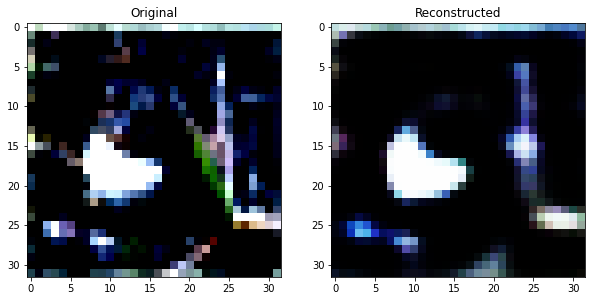


Epoch 3: loss: 0.65863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 3: loss: 0.64540


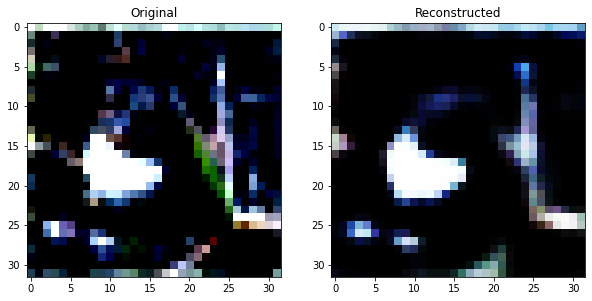


Epoch 4: loss: 0.65371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 4: loss: 0.64313


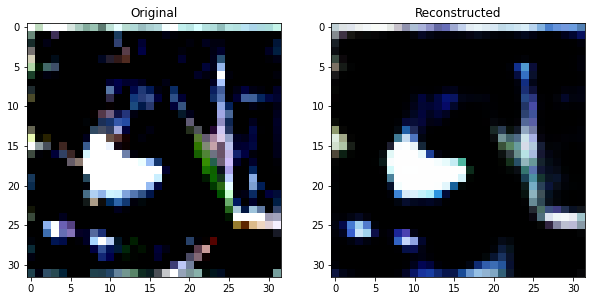


Epoch 5: loss: 0.65080


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 5: loss: 0.64135


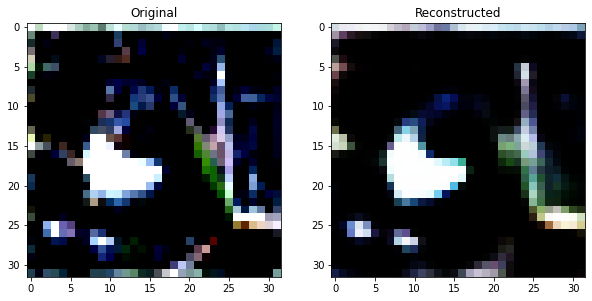


Epoch 6: loss: 0.64938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 6: loss: 0.63970


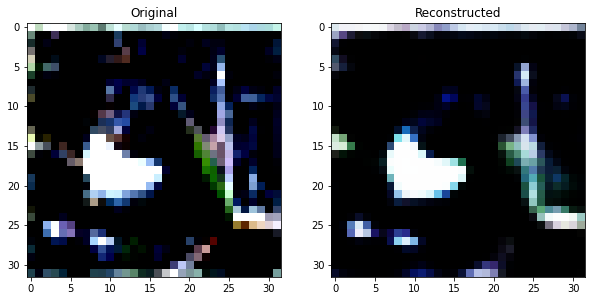


Epoch 7: loss: 0.64764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 7: loss: 0.63772


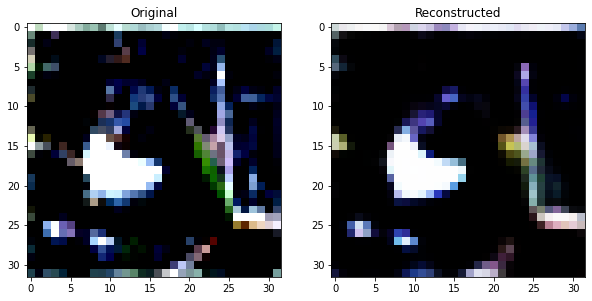


Epoch 8: loss: 0.64656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 8: loss: 0.63633


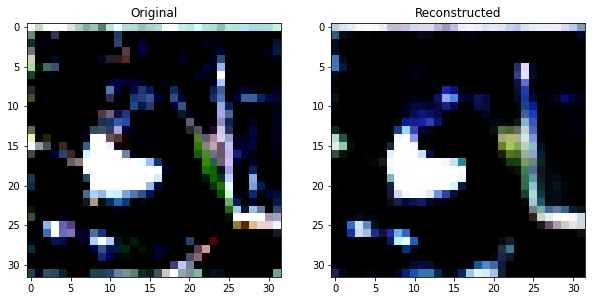


Epoch 9: loss: 0.64578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 9: loss: 0.63565


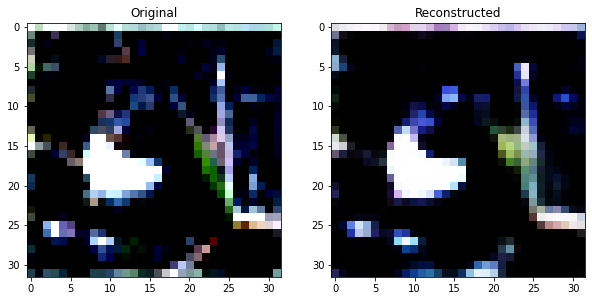


Epoch 10: loss: 0.64489


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 10: loss: 0.63598


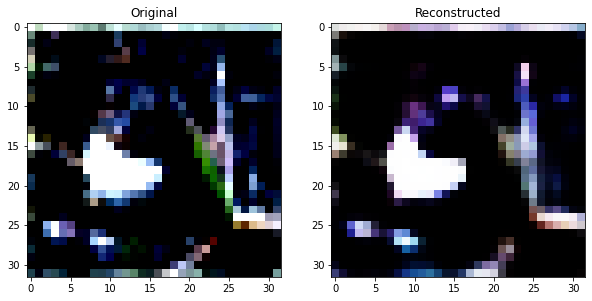


Epoch 11: loss: 0.64447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 11: loss: 0.63509


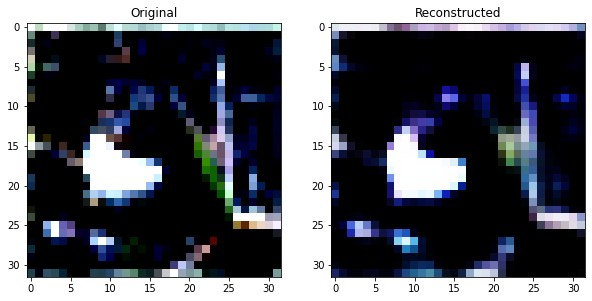


Epoch 12: loss: 0.64406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 12: loss: 0.63541


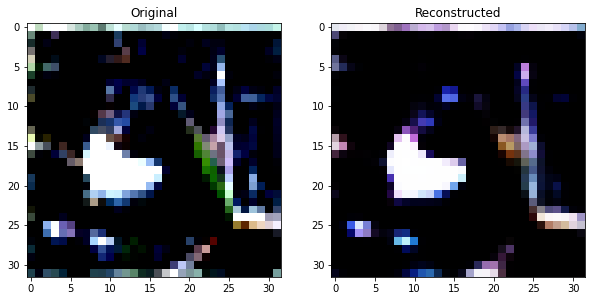


Epoch 13: loss: 0.64366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 13: loss: 0.63400


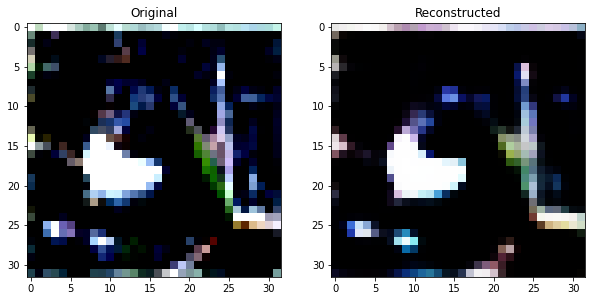


Epoch 14: loss: 0.64292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 14: loss: 0.63298


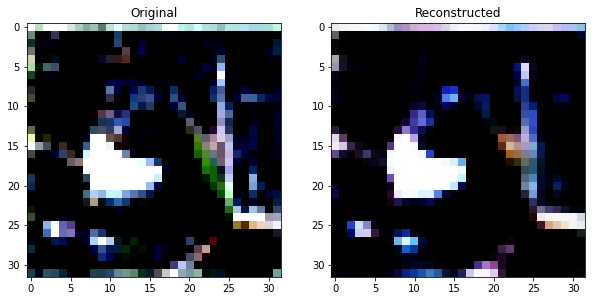


Epoch 15: loss: 0.64267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 15: loss: 0.63320


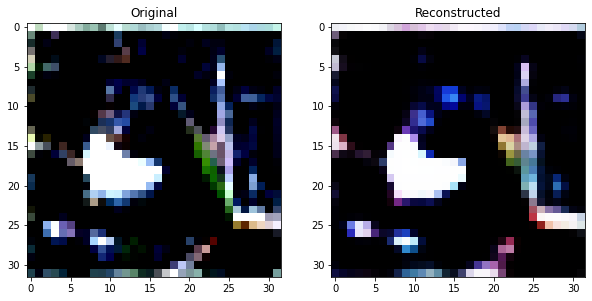


Epoch 16: loss: 0.64192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 16: loss: 0.63204


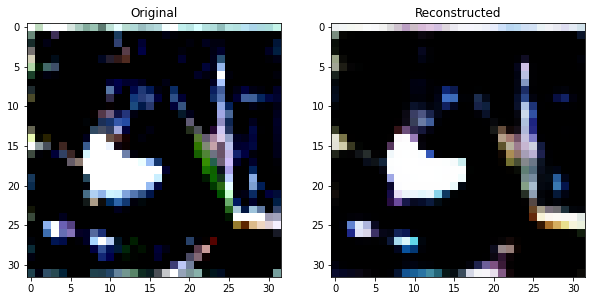


Epoch 17: loss: 0.64124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 17: loss: 0.63135


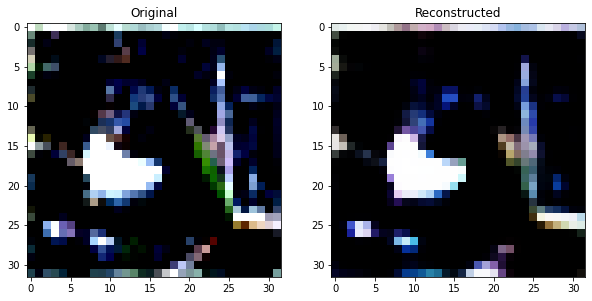


Epoch 18: loss: 0.64076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 18: loss: 0.63168


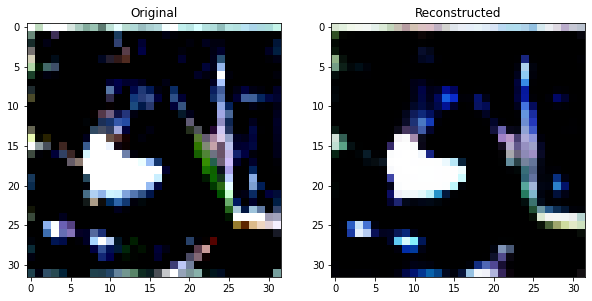


Epoch 19: loss: 0.64034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 19: loss: 0.63059


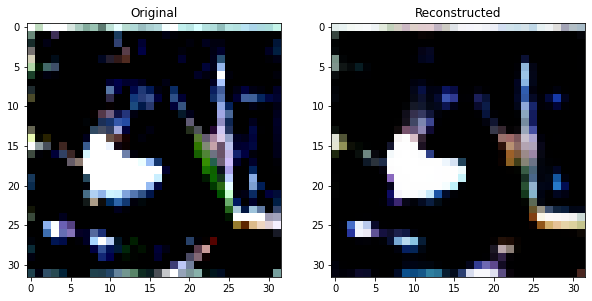


Epoch 20: loss: 0.63973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 20: loss: 0.63087


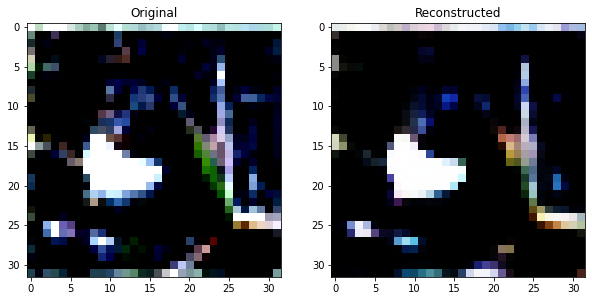


Epoch 21: loss: 0.63936


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 21: loss: 0.63028


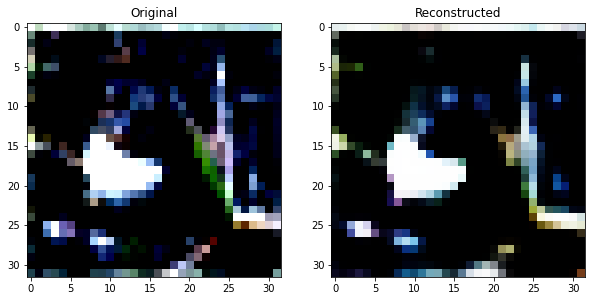


Epoch 22: loss: 0.63908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 22: loss: 0.62985


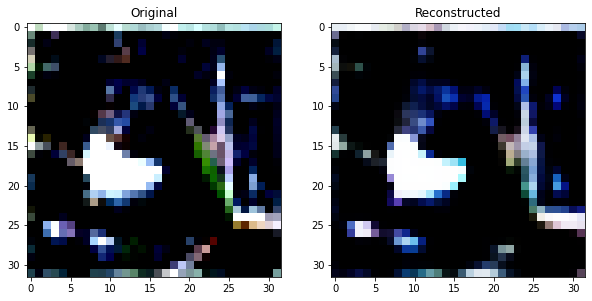


Epoch 23: loss: 0.63879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 23: loss: 0.62972


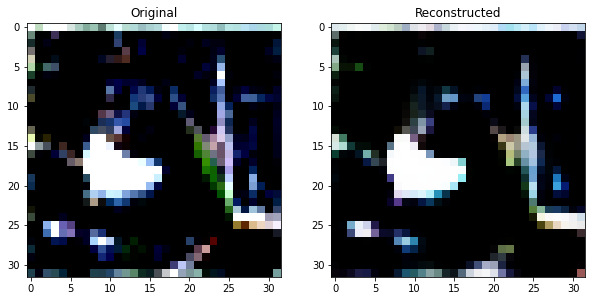


Epoch 24: loss: 0.63853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 24: loss: 0.62921


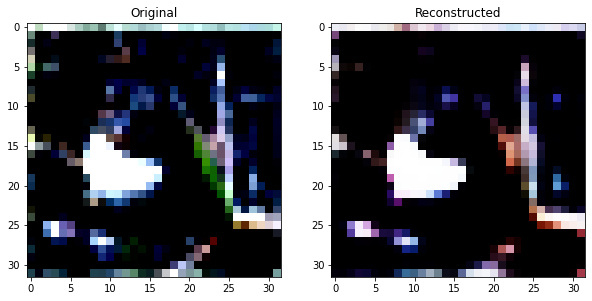


Epoch 25: loss: 0.63797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 25: loss: 0.62872


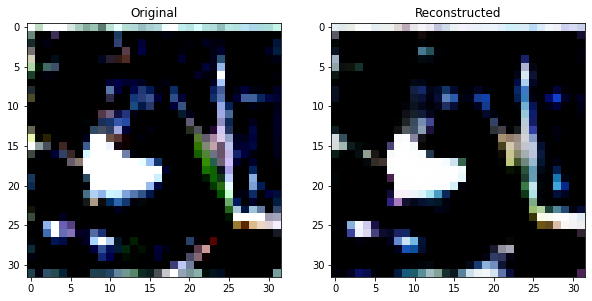


Epoch 26: loss: 0.63782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 26: loss: 0.62854


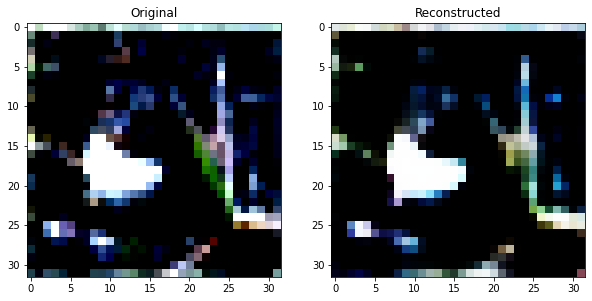


Epoch 27: loss: 0.63740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 27: loss: 0.62836


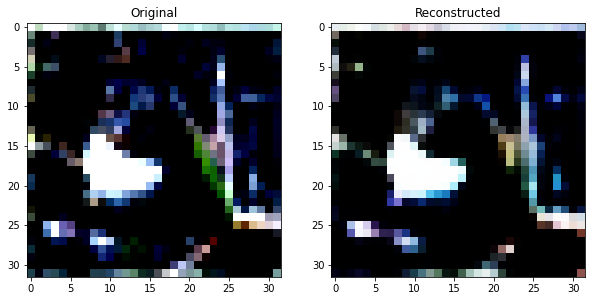


Epoch 28: loss: 0.63711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 28: loss: 0.62804


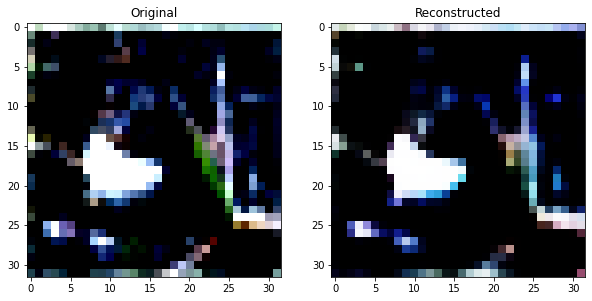


Epoch 29: loss: 0.63666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 29: loss: 0.62762


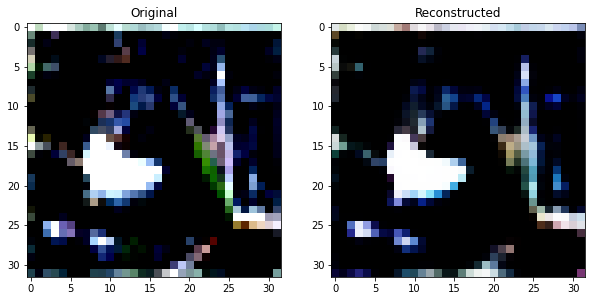


Epoch 30: loss: 0.63656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Val 30: loss: 0.62740


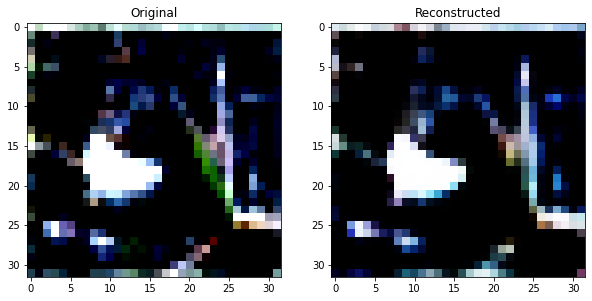

In [19]:
for epoch in range(num_epochs):
  epoch_loss = 0.
  for (data, _) in tqdm.notebook.tqdm(train_dl):
    net.train()
    data = data.to(device)
    optimizer.zero_grad()
    output = net(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()
  print("Epoch {}: loss: {:.5f}".format(epoch+1, epoch_loss/len(train_ds)))

  val_loss = 0. 
  for (data, _) in tqdm.notebook.tqdm(test_dl):
    net.eval()
    data = data.to(device)
    with torch.no_grad():
      output = net(data)
      loss = criterion(output, data)
    val_loss += loss.item()
  print("Val {}: loss: {:.5f}".format(epoch+1, val_loss/len(test_ds)))

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(data[idx].cpu().detach().permute(1,2,0))
  plt.title('Original')
  plt.subplot(1,2,2)
  plt.imshow(output[idx].cpu().detach().permute(1,2,0))
  plt.title('Reconstructed')

plt.pause(0.01)

In [0]:
ae_net = copy.deepcopy(net.get_enc())
torch.save(ae_net.state_dict(),'./200405cae_cifar10.h5')

In [61]:
enc = CAE().get_enc()
i_net = torch.nn.Sequential(
    enc,
    torch.nn.Flatten(),
    torch.nn.Linear(4*256,10),
    # torch.nn.Softmax()
)
i_net = i_net.to(device)
i_net(next(iter(train_dl))[0].to(device)).shape

torch.Size([128, 10])

In [67]:
ae_net = CAE().get_enc()
ae_net.load_state_dict(torch.load('./200405cae_cifar10.h5'))
for param in ae_net.parameters():
  param.requires_grad = False
fp_net = torch.nn.Sequential(
    ae_net,
    torch.nn.Flatten(),
    torch.nn.Linear(4*256,10),
    # torch.nn.Softmax()
)
fp_net = fp_net.to(device)
fp_net(next(iter(train_dl))[0].to(device)).shape

torch.Size([128, 10])

In [68]:
ae_net = CAE().get_enc()
ae_net.load_state_dict(torch.load('./200405cae_cifar10.h5'))
p_net = torch.nn.Sequential(
    ae_net,
    torch.nn.Flatten(),
    torch.nn.Linear(4*256,10),
    # torch.nn.Softmax()
)
p_net = p_net.to(device)
p_net(next(iter(train_dl))[0].to(device)).shape

torch.Size([128, 10])

In [0]:
criterion = torch.nn.CrossEntropyLoss()
p_optimizer = torch.optim.Adam(p_net.parameters(), lr=lr)
fp_optimizer = torch.optim.Adam(fp_net.parameters(), lr=lr)
i_optimizer = torch.optim.Adam(i_net.parameters(),lr=lr)

In [0]:
def train(net, optimizer):
  res_dict = {'acc':[],
              'loss':[],
              'val_acc':[],
              'val_loss':[]}
  for epoch in range(num_epochs):
    epoch_loss,epoch_corr = 0., 0.
    for (data, label) in tqdm.notebook.tqdm(train_dl):
      net.train()
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = net(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      epoch_loss+=loss.item()*data.size(0)
      epoch_corr += sum(label==torch.argmax(output,1)).item()

    l = epoch_loss/len(train_ds)
    a = epoch_corr/len(train_ds)
    res_dict['acc'].append(a)
    res_dict['loss'].append(l)
    print("Epoch {}: Acc:{:.5f} Loss: {:.5f}".format(epoch+1, a,l))

    val_loss, val_corr = 0. , 0.
    for (data, label) in tqdm.notebook.tqdm(test_dl):
      net.eval()
      data, label = data.to(device), label.to(device)
      with torch.no_grad():
        output = net(data)
        loss = criterion(output, label)
        
      # loss function returns averaged loss over one minibatch
      val_loss += loss.item()*data.size(0)
      val_corr += sum(label==torch.argmax(output,1)).item()
    
    l = val_loss/len(test_ds)
    a = val_corr/len(test_ds)
    res_dict['val_acc'].append(a)
    res_dict['val_loss'].append(l)
    print("Val {}: Acc: {:.5f} Loss: {:.5f}".format(epoch+1,a ,l ))

  return res_dict

In [71]:
i_dict = train(i_net, i_optimizer)


Epoch 1: Acc:0.66792 Loss: 0.00730



Val 1: Acc: 0.66940 Loss: 0.00094



Epoch 2: Acc:0.72448 Loss: 0.00615



Val 2: Acc: 0.72270 Loss: 0.00080



Epoch 3: Acc:0.75682 Loss: 0.00539



Val 3: Acc: 0.70870 Loss: 0.00086



Epoch 4: Acc:0.78372 Loss: 0.00480



Val 4: Acc: 0.72790 Loss: 0.00080



Epoch 5: Acc:0.80864 Loss: 0.00430



Val 5: Acc: 0.74390 Loss: 0.00076



Epoch 6: Acc:0.83300 Loss: 0.00377



Val 6: Acc: 0.74580 Loss: 0.00078



Epoch 7: Acc:0.84666 Loss: 0.00341



Val 7: Acc: 0.74510 Loss: 0.00079



Epoch 8: Acc:0.86408 Loss: 0.00305



Val 8: Acc: 0.74280 Loss: 0.00081



Epoch 9: Acc:0.87818 Loss: 0.00271



Val 9: Acc: 0.75450 Loss: 0.00079



Epoch 10: Acc:0.89420 Loss: 0.00237



Val 10: Acc: 0.75260 Loss: 0.00083



Epoch 11: Acc:0.90788 Loss: 0.00210



Val 11: Acc: 0.75320 Loss: 0.00084



Epoch 12: Acc:0.91700 Loss: 0.00187



Val 12: Acc: 0.75280 Loss: 0.00088



Epoch 13: Acc:0.92902 Loss: 0.00163



Val 13: Acc: 0.75210 Loss: 0.00091



Epoch 14: Acc:0.93266 Loss: 0.00149



Val 14: Acc: 0.74810 Loss: 0.00094



Epoch 15: Acc:0.94534 Loss: 0.00124



Val 15: Acc: 0.74530 Loss: 0.00101



Epoch 16: Acc:0.94662 Loss: 0.00119



Val 16: Acc: 0.75070 Loss: 0.00101



Epoch 17: Acc:0.95538 Loss: 0.00102



Val 17: Acc: 0.75440 Loss: 0.00102



Epoch 18: Acc:0.96112 Loss: 0.00090



Val 18: Acc: 0.76050 Loss: 0.00102



Epoch 19: Acc:0.96388 Loss: 0.00083



Val 19: Acc: 0.75360 Loss: 0.00108



Epoch 20: Acc:0.96244 Loss: 0.00083



Val 20: Acc: 0.75160 Loss: 0.00110



Epoch 21: Acc:0.96728 Loss: 0.00073



Val 21: Acc: 0.75290 Loss: 0.00112



Epoch 22: Acc:0.96956 Loss: 0.00068



Val 22: Acc: 0.76200 Loss: 0.00112



Epoch 23: Acc:0.97256 Loss: 0.00062



Val 23: Acc: 0.75890 Loss: 0.00117



Epoch 24: Acc:0.97380 Loss: 0.00059



Val 24: Acc: 0.75910 Loss: 0.00113



Epoch 25: Acc:0.97534 Loss: 0.00055



Val 25: Acc: 0.75500 Loss: 0.00122



Epoch 26: Acc:0.97586 Loss: 0.00055



Val 26: Acc: 0.75750 Loss: 0.00123



Epoch 27: Acc:0.97710 Loss: 0.00051



Val 27: Acc: 0.76030 Loss: 0.00124



Epoch 28: Acc:0.97452 Loss: 0.00057



Val 28: Acc: 0.75740 Loss: 0.00127



Epoch 29: Acc:0.97608 Loss: 0.00053



Val 29: Acc: 0.75570 Loss: 0.00128



Epoch 30: Acc:0.97966 Loss: 0.00045



Val 30: Acc: 0.75730 Loss: 0.00130


In [72]:
p_dict = train(p_net, p_optimizer)


Epoch 1: Acc:0.51042 Loss: 0.01063



Val 1: Acc: 0.58450 Loss: 0.00116



Epoch 2: Acc:0.63976 Loss: 0.00799



Val 2: Acc: 0.63790 Loss: 0.00103



Epoch 3: Acc:0.69224 Loss: 0.00679



Val 3: Acc: 0.67220 Loss: 0.00093



Epoch 4: Acc:0.72936 Loss: 0.00601



Val 4: Acc: 0.70460 Loss: 0.00086



Epoch 5: Acc:0.75774 Loss: 0.00539



Val 5: Acc: 0.71070 Loss: 0.00084



Epoch 6: Acc:0.78116 Loss: 0.00490



Val 6: Acc: 0.71900 Loss: 0.00082



Epoch 7: Acc:0.79904 Loss: 0.00451



Val 7: Acc: 0.73280 Loss: 0.00080



Epoch 8: Acc:0.81934 Loss: 0.00407



Val 8: Acc: 0.72180 Loss: 0.00085



Epoch 9: Acc:0.83274 Loss: 0.00377



Val 9: Acc: 0.73870 Loss: 0.00084



Epoch 10: Acc:0.84460 Loss: 0.00349



Val 10: Acc: 0.73160 Loss: 0.00085



Epoch 11: Acc:0.85872 Loss: 0.00318



Val 11: Acc: 0.73340 Loss: 0.00088



Epoch 12: Acc:0.86956 Loss: 0.00294



Val 12: Acc: 0.73340 Loss: 0.00090



Epoch 13: Acc:0.88130 Loss: 0.00265



Val 13: Acc: 0.72710 Loss: 0.00096



Epoch 14: Acc:0.89010 Loss: 0.00247



Val 14: Acc: 0.73340 Loss: 0.00097



Epoch 15: Acc:0.90132 Loss: 0.00221



Val 15: Acc: 0.73310 Loss: 0.00103



Epoch 16: Acc:0.90728 Loss: 0.00206



Val 16: Acc: 0.72360 Loss: 0.00108



Epoch 17: Acc:0.91452 Loss: 0.00192



Val 17: Acc: 0.72850 Loss: 0.00108



Epoch 18: Acc:0.92486 Loss: 0.00169



Val 18: Acc: 0.73330 Loss: 0.00111



Epoch 19: Acc:0.93154 Loss: 0.00156



Val 19: Acc: 0.72730 Loss: 0.00117



Epoch 20: Acc:0.93814 Loss: 0.00139



Val 20: Acc: 0.71740 Loss: 0.00128



Epoch 21: Acc:0.94002 Loss: 0.00134



Val 21: Acc: 0.73710 Loss: 0.00120



Epoch 22: Acc:0.94516 Loss: 0.00122



Val 22: Acc: 0.73520 Loss: 0.00126



Epoch 23: Acc:0.95164 Loss: 0.00109



Val 23: Acc: 0.73440 Loss: 0.00131



Epoch 24: Acc:0.95470 Loss: 0.00101



Val 24: Acc: 0.73780 Loss: 0.00137



Epoch 25: Acc:0.95814 Loss: 0.00092



Val 25: Acc: 0.73310 Loss: 0.00141



Epoch 26: Acc:0.95816 Loss: 0.00091



Val 26: Acc: 0.73050 Loss: 0.00144



Epoch 27: Acc:0.96524 Loss: 0.00075



Val 27: Acc: 0.73010 Loss: 0.00150



Epoch 28: Acc:0.96358 Loss: 0.00081



Val 28: Acc: 0.73120 Loss: 0.00152



Epoch 29: Acc:0.96548 Loss: 0.00074



Val 29: Acc: 0.73370 Loss: 0.00157



Epoch 30: Acc:0.96740 Loss: 0.00069



Val 30: Acc: 0.73210 Loss: 0.00159


In [73]:
fp_dict = train(fp_net, fp_optimizer)


Epoch 1: Acc:0.38458 Loss: 0.01408



Val 1: Acc: 0.41960 Loss: 0.00167



Epoch 2: Acc:0.43412 Loss: 0.01289



Val 2: Acc: 0.43890 Loss: 0.00161



Epoch 3: Acc:0.44874 Loss: 0.01254



Val 3: Acc: 0.44310 Loss: 0.00159



Epoch 4: Acc:0.45346 Loss: 0.01235



Val 4: Acc: 0.45050 Loss: 0.00157



Epoch 5: Acc:0.46208 Loss: 0.01221



Val 5: Acc: 0.45720 Loss: 0.00155



Epoch 6: Acc:0.46350 Loss: 0.01211



Val 6: Acc: 0.45730 Loss: 0.00155



Epoch 7: Acc:0.46818 Loss: 0.01202



Val 7: Acc: 0.46060 Loss: 0.00154



Epoch 8: Acc:0.46862 Loss: 0.01196



Val 8: Acc: 0.46340 Loss: 0.00153



Epoch 9: Acc:0.47270 Loss: 0.01188



Val 9: Acc: 0.46480 Loss: 0.00152



Epoch 10: Acc:0.47412 Loss: 0.01183



Val 10: Acc: 0.46930 Loss: 0.00152



Epoch 11: Acc:0.47608 Loss: 0.01178



Val 11: Acc: 0.47300 Loss: 0.00151



Epoch 12: Acc:0.47756 Loss: 0.01172



Val 12: Acc: 0.46980 Loss: 0.00151



Epoch 13: Acc:0.47950 Loss: 0.01169



Val 13: Acc: 0.47540 Loss: 0.00150



Epoch 14: Acc:0.47940 Loss: 0.01167



Val 14: Acc: 0.47360 Loss: 0.00150



Epoch 15: Acc:0.48152 Loss: 0.01163



Val 15: Acc: 0.47770 Loss: 0.00150



Epoch 16: Acc:0.48350 Loss: 0.01159



Val 16: Acc: 0.48030 Loss: 0.00149



Epoch 17: Acc:0.48280 Loss: 0.01155



Val 17: Acc: 0.48120 Loss: 0.00149



Epoch 18: Acc:0.48384 Loss: 0.01154



Val 18: Acc: 0.48460 Loss: 0.00148



Epoch 19: Acc:0.48686 Loss: 0.01151



Val 19: Acc: 0.48100 Loss: 0.00148



Epoch 20: Acc:0.48774 Loss: 0.01149



Val 20: Acc: 0.48180 Loss: 0.00148



Epoch 21: Acc:0.48844 Loss: 0.01147



Val 21: Acc: 0.48250 Loss: 0.00148



Epoch 22: Acc:0.48930 Loss: 0.01144



Val 22: Acc: 0.48360 Loss: 0.00148



Epoch 23: Acc:0.48976 Loss: 0.01142



Val 23: Acc: 0.48770 Loss: 0.00147



Epoch 24: Acc:0.49022 Loss: 0.01140



Val 24: Acc: 0.48410 Loss: 0.00147



Epoch 25: Acc:0.49168 Loss: 0.01138



Val 25: Acc: 0.48630 Loss: 0.00147



Epoch 26: Acc:0.49230 Loss: 0.01136



Val 26: Acc: 0.48680 Loss: 0.00147



Epoch 27: Acc:0.49284 Loss: 0.01134



Val 27: Acc: 0.48860 Loss: 0.00147



Epoch 28: Acc:0.49272 Loss: 0.01133



Val 28: Acc: 0.48690 Loss: 0.00146



Epoch 29: Acc:0.49290 Loss: 0.01132



Val 29: Acc: 0.48610 Loss: 0.00146



Epoch 30: Acc:0.49364 Loss: 0.01130



Val 30: Acc: 0.49080 Loss: 0.00146


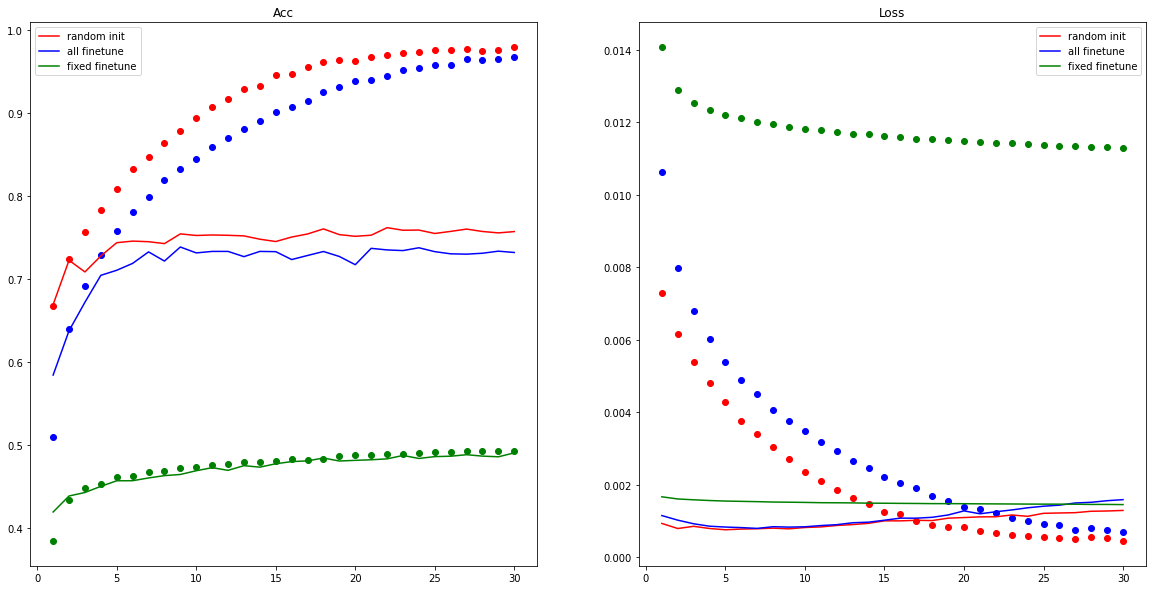

In [76]:
import matplotlib.pyplot as plt
epochs = range(1,num_epochs+1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Acc')
#train
plt.plot(epochs, i_dict['acc'],'ro')
plt.plot(epochs, p_dict['acc'], 'bo')
plt.plot(epochs, fp_dict['acc'],'go')
#val
plt.plot(epochs, i_dict['val_acc'],'r',label='random init')
plt.plot(epochs, p_dict['val_acc'], 'b', label='all finetune')
plt.plot(epochs, fp_dict['val_acc'],'g',label='fixed finetune')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
#train
plt.plot(epochs, i_dict['loss'],'ro')
plt.plot(epochs, p_dict['loss'], 'bo')
plt.plot(epochs, fp_dict['loss'],'go')
#val
plt.plot(epochs, i_dict['val_loss'],'r',label='random init')
plt.plot(epochs, p_dict['val_loss'], 'b', label='all finetune')
plt.plot(epochs, fp_dict['val_loss'],'g',label='fixed finetune')
plt.legend()